In [9]:
%matplotlib inline
import pandas as pd
import os
import random
import re
import nltk
import gensim
import string
import urllib2
import math
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from gensim import corpora
from gensim.models import LdaMulticore
from collections import defaultdict
import copy as cp
from bs4 import BeautifulSoup
from functools import reduce 
import operator
import matplotlib.pyplot as plt
import pprint

In [ ]:
# find out what data this expects, e.g., with green_data (list of lists?) -- yes
# replace with file data

## Webscraping with Beautiful Soup
This is legagy code. Produce legacy 

In [5]:
#read in the csv files with URLS
green = pd.read_csv("../../data/green_business_urls.csv")
synbio = pd.read_csv("../../data/synbio_business_urls.csv")
nano = pd.read_csv("../../data/nano_business_urls.csv")
#get lists of the urls
green_urls = list(green['lower_url'])
synbio_urls = list(synbio['lower_url'])
nano_urls = list(nano['lower_url'])

In [6]:
missed = []
def get_data(url):
    '''
    Function to extract the visible text data from a given URL
    '''
    try:
        if url.startswith("http"):
            html = urllib2.urlopen(url).read()
        else:
            html = urllib2.urlopen("http://" + url).read()
        soup = BeautifulSoup(html, 'lxml')
        [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
        visible_text = soup.getText()
        text =  [item.strip() for item in visible_text.split("\n") if not item.strip() == ""]
        return text
    except:
        missed.append(url)
#filter out the few null results
green_data = filter(lambda x : x and len(x) > 1, [get_data(item) for item in green_urls])
# synbio_data = filter(lambda x : x and len(x) > 1, [get_data(item) for item in synbio_urls])
# nano_data = filter(lambda x : x and len(x) > 1, [get_data(item) for item in nano_urls])

In [10]:
#check that we have the expected number of documents
print len(green_data)

# print len(synbio_data)
# print len(nano_data)

pp = pprint.PrettyPrinter()
pp.pprint(green_data)

22
[[u'AltaRock Energy',
  u'About Us',
  u'Technology',
  u'Projects',
  u'Newsroom',
  u'Contact',
  u'AltaRock Services AltaRock Services LLC is a wholly-owned subsidiary of AltaRock Energy providing a full suite of geothermal services including development, management, operations, performance improvement and reservoir maintenance for new and existing geothermal projects.',
  u'Learn more.',
  u'Clean Energy Partners Clean Energy Partners is an AltaRock Energy company established for the purpose of building the leading portfolio of clean, baseload power assets by leveraging the unique advantages of next generation enhanced geothermal energy (EGS).',
  u'Learn more.',
  u'AltaRock Proposes a Renewable Energy Breakthrough',
  u'Recent Media Coverage',
  u'Workshop at Newberry announced',
  u'July 11, 2017',
  u'Newberry Vies for Geothermal Lab Spot',
  u'June 28, 2016',
  u'Tapping Into Geothermal Energy',
  u'June 21, 2016',
  u'Home',
  u'Projects',
  u'Technology',
  u'About Us',
 

  u'Lab & Analytical Equipment',
  u'View Now',
  u'Sampling, preparation, detection, measurement, and monitoring liquids, solids, and gases; the very nature of laboratory and analytical equipment demands accuracy and repeatability. So. when your application requires heat, choosing the best source of advanced thermal technology solutions to meet the demands of your application is paramount. That source is Chromalox.',
  u'Bio-Pharmaceutical',
  u'View Now',
  u'Chromalox is a leader in designed systems because we control the manufacturing process from the first component to the finished product. While some companies simply assemble purchased parts, our vertical integration of product manufacturing allows tight control of all procedures. Because Chromalox manufactures the component parts, we can adjust to meet your critical requirements.',
  u'Building & Construction',
  u'View Now',
  u'When you\u2019re facing tight deadlines, you can\u2019t let cold weather or a delayed turnaround fro

## Data Prep

#### Prepare text for topic modelling

In [154]:
#tokenize text for topic modelling
def encode_item(text):
    '''
    Remove characters with encoding problems 
    '''
    clean = ""
    for item in text.split(" "):
        try:
            clean += str(item).encode('ascii','ignore') + " "
        except: 
            pass
    return clean.rstrip()

stopwords = nltk.corpus.stopwords.words('english') + list(set(string.punctuation))
stemmer = SnowballStemmer("english")

def stem_tokenizer(text):
    '''
    Tokenize and stem an input sentence"
    '''
    words_stemmed = filter(lambda x : not x in stopwords, [stemmer.stem(word) for word in nltk.word_tokenize(text)])
    return words_stemmed

def return_for_model(text):
    '''
    Deal with endcoding and return stemmed/tokenized text
    '''
    all_content = [encode_item(item) for item in text]
    all_content_stem_token = map(stem_tokenizer, all_content)
    return all_content_stem_token

In [155]:
def process_doc_list(list_of_docs):
    '''
    input: lists of documents (which are individually lists of paragraphs)
    output: returns a test/train split of paragraphs and stemmed documents
    '''
    combined_text = []
    documents = []
    for document in list_of_docs:
        text = filter(lambda x : not x in [' ', '', '\t'],document) #remove empty paragraphs
        #loop over text and add title elements to the paragraph they describe
        joined = []
        join = False
        for i in range(len(text)):
            if len(text[i]) < 40:
                join = True
            else:
                if join:
                    joined.append(text[i-1] + " " + text[i])
                else:
                    joined.append(text[i])
        combined_text +=joined # make a big list
        documents.append(joined) #make a list of lists
    combined = return_for_model(combined_text)
    random.shuffle(combined) #randomly shuffle in order to make test train split
    train_index = int(np.round(len(combined)*.8)) #about 80% in the training set
    train = combined[:train_index]
    test = combined[train_index:]
    as_documents = [return_for_model(doc) for doc in documents]
    return train, test, as_documents

#### Process Documents for Topic Modelling

In [156]:
#use the preceeding fuction to process the text data
green_train, green_test, green_docs = process_doc_list(green_data)
synbio_train, synbio_test, synbio_docs = process_doc_list(synbio_data)
nano_train, nano_test, nano_docs = process_doc_list(nano_data)

## Run Topic Modelling

In [157]:
def topic_model(train, test, topics = 10):
    '''
    input: preprocessed test and training data, optionally the number of topics
    output: a fitted LDA topic model and the bow representation of test data for model evaluation
    '''
    random.seed(1)
    #create topic model on full text
    #will need to run on server when we have more data
    full_dict = corpora.Dictionary(train)
    DT_matrix = [full_dict.doc2bow(doc) for doc in train]
    test_token = [full_dict.doc2bow(doc) for doc in test]
    lda = LdaMulticore(DT_matrix, id2word=full_dict, num_topics=topics) 
    return lda, test_token

In [144]:
k = [2, 5, 10, 15, 20, 25, 30, 40 , 50, 60, 100] #possible number of topics
def calculate_perplexities(train,test, k):
    '''
    inputs: preprocessed test and training data, a list of possible number of topics
    outputs: log perplexity and perplexity, scored on the test set
    '''
    log_perplexities = []
    perplexity = []
    for i in k:
        model, test_doc2bow = topic_model(train, test, i)
        log_p = model.log_perplexity(test_doc2bow)
        log_perplexities.append(log_p)
        perp = model.bound(test_doc2bow)
        perplexity.append(perp)
    return log_perplexities, perplexity

green_log_perplexities, green_perplexities = calculate_perplexities(green_train, green_test, k)
synbio_log_perplexities, synbio_perplexities = calculate_perplexities(synbio_train, synbio_test, k)
nano_log_perplexities,nano_perplexities= calculate_perplexities(nano_train, nano_test, k)

#### Perplexity Plots for each Website type

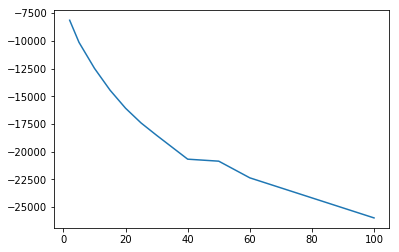

In [145]:
import matplotlib.pyplot as plt
plt.plot(k, green_perplexities)

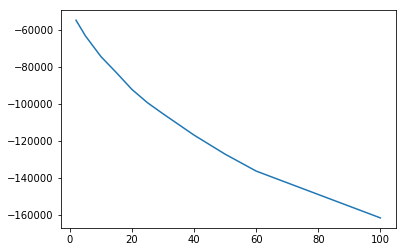

In [146]:
plt.plot(k, synbio_perplexities)

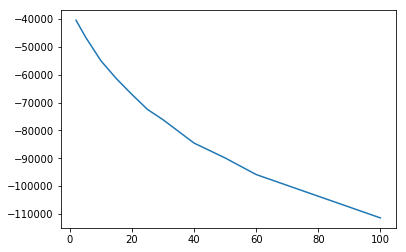

In [147]:
plt.plot(k, nano_perplexities)

#### Predict topics by paragraph

In [13]:
#identify topics by paragraph
topic_vector = []
for doc in by_document:
    main_topic = []
    for para in doc:
        topic_by_prob = sorted([(i[1],i[0]) for i in lda.get_document_topics(full_dict.doc2bow(para))], reverse = True)
        main_topic.append(topic_by_prob[0][1])
        topic_prob = topic_by_prob[0][0] #in case we want it later
    topic_vector.append(main_topic)
#add start and end keys for topic_vector
for doc in topic_vector:
    doc.insert(0, "start")
    doc.append("end")

In [14]:
topic_vector[1]

['start', 1, 0, 2, 1, 1, 1, 3, 3, 1, 3, 2, 1, 1, 0, 3, 3, 0, 3, 0, 0, 'end']

### Markov Model

In [15]:
from collections import defaultdict
import random

In [21]:
class markov_representation():
    def __init__(self):
        self.tokens = defaultdict(lambda: 0)
        self.transitions = defaultdict(lambda: defaultdict(lambda:0))
        self.for_matrix = defaultdict(lambda: 0)
    def add(self, list_of_tokens):
        for i in range(len(list_of_tokens) ):
            if i <= (len(list_of_tokens)-2):
                self.tokens[str(list_of_tokens[i])]+=1
                self.transitions[str(list_of_tokens[i])][str(list_of_tokens[i + 1])]+=1
                self.for_matrix[(str(list_of_tokens[i]),str(list_of_tokens[i + 1]))] +=1
            else: #separate block to add the last token to the list of tokens
                self.tokens[str(list_of_tokens[i])]+=1
                self.transitions[str(list_of_tokens[i])][None] +=1
    def test(self):
        #return self.transitions
        return self.for_matrix
    #to do: add transition matrix
    def make_transition_matrix(self):
        #tranform dictionary of tuples in self.for_matrix into matrix
        pass
    def generate_sequence(self):
        topic = 'start'
        document = ['start']
        while topic != 'end' and len(document)<20:
            options = self.transitions[topic]
            total = sum(options.values())
            temp = 0
            threshold = random.randint(0, total-1)
            for key, value in options.iteritems():
                temp += value
                if temp>threshold:
                    topic = key
                    break
            document.append(topic)
        if document[-1] != 'end':
            document.append('end')
        return document
        #I want to recursively call this to generate a sequence of the required length, but pass on this for now
#         if len(document) > min_length:
#             return document
#         else:
#             return self.generate_sequence(self, 5)

### Apply Model

In [23]:
model = markov_representation()
for doc in topic_vector:
    model.add(doc)
model.generate_sequence()

['start', '2', '1', '1', '0', 'end']

In [ ]:
## add code to get transition matrix

In [24]:
model.test()

defaultdict(<function __main__.<lambda>>,
            {('0', '0'): 7,
             ('0', '1'): 4,
             ('0', '2'): 4,
             ('0', '3'): 5,
             ('0', 'end'): 2,
             ('1', '0'): 9,
             ('1', '1'): 25,
             ('1', '2'): 4,
             ('1', '3'): 5,
             ('1', 'end'): 4,
             ('2', '0'): 1,
             ('2', '1'): 8,
             ('2', '2'): 17,
             ('2', '3'): 4,
             ('2', 'end'): 3,
             ('3', '0'): 5,
             ('3', '1'): 5,
             ('3', '2'): 4,
             ('3', '3'): 11,
             ('3', 'end'): 1,
             ('start', '1'): 5,
             ('start', '2'): 4,
             ('start', '3'): 1})